Sheet 2.4: Character-level sequence modeling w/ RNNs
====================================================

**Author:** Michael Franke



The goal of this tutorial is to get familiar with simple language models.
To be able to have a manageable (quick to train, evaluate, inspect) case study, we look at character-level predictions of surnames from different languages.
(The inspiration and source of this notebook is [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) from PyTorch&rsquo;s documentation.)



## Packages & global parameters



In addition to the usual packages for neural network modeling, we will also require packages for I/O and string handling.



In [2]:
##################################################
## import packages
##################################################

from __future__ import unicode_literals, print_function, division
import json
import pandas
import string
import torch
import urllib.request
import numpy as np
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## Loading & inspecting the data



Our training data are lists of surnames from different countries.
We will use this data set to train a model that predicts a name, given the country as a prompt.

The (pre-processed) data is stored in a JSON file.
We load it and define a few useful variables for later use.



In [4]:

##################################################
## read and inspect the data
##################################################
with urllib.request.urlopen(
    "https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/05-RNNs/names-data.json"
) as url:
    names_data = json.load(url)

# # local import
# with open('names-data.json') as dataFile:
#     names_data = json.load(dataFile)

categories = list(names_data.keys())
n_categories = len(categories)
print(categories)
print(n_categories)
for country in names_data:
    # Get all names for the country
    names = names_data[country]
    print(country, "has ", len(names), " names")

    from collections import Counter
    name_counts = Counter(names)
    print(f"Unique name count:", len(name_counts))

    sorted_names = sorted(name_counts.items(), key=lambda x: x[1], reverse=True)
    for name, count in sorted_names[:10]:
        print(f"  {name}: {count}")


# Use all ASCII letters as vocabulary (plus tokens [EOS], [SOS])
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 2  # all letter + [EOS] and [SOS]
SOSIndex = n_letters - 1
EOSIndex = n_letters - 2


['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
18
Czech has  519  names
Unique name count: 502
  Blazek: 2
  Cermak: 2
  Cerny: 2
  Hanek: 2
  Kafka: 2
  Kocian: 2
  Kouba: 2
  Marik: 2
  Navratil: 2
  Ponec: 2
German has  724  names
Unique name count: 690
  Sommer: 4
  Kruger: 3
  Armbruster: 2
  Baumgartner: 2
  Bosch: 2
  Ebner: 2
  Groel: 2
  Gunther: 2
  Holzer: 2
  Horn: 2
Arabic has  2000  names
Unique name count: 108
  Tahan: 28
  Fakhoury: 28
  Nader: 27
  Koury: 27
  Mustafa: 26
  Antar: 26
  Sarraf: 26
  Hadad: 26
  Kassis: 26
  Shadid: 25
Japanese has  991  names
Unique name count: 990
  Okuma: 2
  Abe: 1
  Abukara: 1
  Adachi: 1
  Aida: 1
  Aihara: 1
  Aizawa: 1
  Ajibana: 1
  Akaike: 1
  Akamatsu: 1
Chinese has  268  names
Unique name count: 246
  Chu: 2
  Fei: 2
  Feng: 2
  Guan: 2
  Guo: 2
  Hong: 2
  Huan: 2
  Jin: 2
  Luo: 

The data consists of two things:
a list of strings, called &ldquo;categories&rdquo;, contains all the categories (languages) for which we have data;
a dictionary, called &ldquo;names_data&rdquo;, contains a list of names for each category.

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.4.1: Inspect the data</span></strong>
>
> 0. [Just for yourself.] Find out what&rsquo;s in the data set. How any different countries do we have? How many names per country? Are all names unique in a given country? Do the names sound typical to your ears for the given countries?
18 countries, all of the names they have are *not* unique.


Click below to see the solution.

In [5]:
for c in names_data:
    for name in names_data[c]:
        if name == "Bruckner":
            print("yes")

names_data

# number of countries
print(f"Number of countries: {n_categories}\n")
# number of names per country
for country in names_data:
    print(f"{country}: {len(names_data[country])}")

# Unique names per country
for country in names_data:
    print(f"{len(names_data[country]) == len(set(names_data[country]))}")

# ---> Most of the name lists contain duplicates.

yes
Number of countries: 18

Czech: 519
German: 724
Arabic: 2000
Japanese: 991
Chinese: 268
Vietnamese: 73
Russian: 9408
French: 277
Irish: 232
English: 3668
Spanish: 298
Greek: 203
Italian: 709
Portuguese: 74
Scottish: 100
Dutch: 297
Korean: 94
Polish: 139
False
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
True
False


## Train-test split



We will split the data into a training and a test set.
Look at the code and try to answer the exercise question of how this split is realized.



In [6]:
##################################################
## make a train/test split
##################################################

train_data = dict()
test_data = dict()
split_percentage = 10
for k in list(names_data.keys()):
    total_size = len(names_data[k])
    test_size = round(total_size / split_percentage)
    train_size = total_size - test_size
    print(k, total_size, train_size, test_size)
    indices = [i for i in range(total_size)]
    random.shuffle(indices)
    train_indices = indices[0:train_size]
    test_indices = indices[(train_size + 1) : (-1)]
    train_data[k] = [names_data[k][i] for i in train_indices]
    test_data[k] = [names_data[k][i] for i in test_indices]

Czech 519 467 52
German 724 652 72
Arabic 2000 1800 200
Japanese 991 892 99
Chinese 268 241 27
Vietnamese 73 66 7
Russian 9408 8467 941
French 277 249 28
Irish 232 209 23
English 3668 3301 367
Spanish 298 268 30
Greek 203 183 20
Italian 709 638 71
Portuguese 74 67 7
Scottish 100 90 10
Dutch 297 267 30
Korean 94 85 9
Polish 139 125 14


> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.4.2: Explain the train-test split</span></strong>
>
> 1. How is the original data information split into training and test set? (E.g., what amount of data is allocated to each part?; is the split exclusive and exhaustive?; how is it determined which item goes where?)

> %10 of each country's data is allocated to test(rounded up) and the rest is to the train. The code randomly shuffles the indices and then splits them into non-overlapping parts. So it is exclusive and since no datapoint is left out, it is also exhaustive.


Click below to see the solution.

```{toggle}
The dataset is split in training- and testset, where 90% are used for training and 10% for testing. The datapoints are shuffled before assignment and therefore randomly assigned. The split is both exclusive and exhaustive.
```

## Defining the model



The model we use is a (hand-crafted) recurrent neural network.
The architecture follows [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html), from where we also borrow the following picture:

![img](https://github.com/CogSciPrag/Understanding-LLMs-course/blob/main/understanding-llms/tutorials/pics/05-RNN-diagram.png?raw=1){width=550px}

The model makes consecutive predictions about the next character.
It is conditioned on three vectors:

1.  &rsquo;category&rsquo; is a one-hot vector encoding the country
2.  &rsquo;input&rsquo; is a one-hot vector encoding the character
3.  &rsquo;hidden&rsquo; is the RNN&rsquo;s hidden state (remembering what happened before)

These vectors are first combined and then used to produce a next-character probability distribution *and* the hidden state to be fed into the next round of predictions.

Next to the usual functions (initialization and forward pass), there is also a function that returns a blank &rsquo;hidden state&rsquo;.
This will be used later during training and inference, because at the start of each application (training or inference) the RNN should have a blank memory.
(It makes sense to include this function in the definition of the module because it depends on the module&rsquo;s parameters (size of the hidden layer).)

Notice that the architecture features a dropout layer, which randomly sets a fixed proportion of units to 0.
The inclusion of dropout introduces a random element in the model during training and inference.



In [7]:
##################################################
## define RNN
##################################################


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden, dropout):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output_combined = self.relu(output_combined)
        output = self.o2o(output_combined)
        if dropout:
            output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.4.3: Inspect the model</span></strong>
>
> 0. [Just for yourself.] Make sure that you understand the model architecture and its implementation. E.g., do you agree that this code implements the model graph shown above? Can you think of slight alterations to the model which might also work?



Click below to see the solutions.

```{toggle}
The model matches the graph in the picture. Not sure what the expected alternation here is. It could be a good idea to limit the dropout layer to training and deactivate for inference. We would have to add an additional parameter to the forward pass as shown above.

Another idea would be to add a non-linear activation function between the combined output layer and the final output layer. This seems to improve training quiet a bit.
```

## Helper functions for training



For training, we will present the model with randomly sampled single items.
This is why we define a &rsquo;random_training_pair&rsquo; function which returns, well, a random training pair (category and name).



In [8]:
##################################################
## helper functions for training
##################################################


# Random item from a list
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]


# Get a random category and random line from that category
def random_training_pair():
    category = random_choice(categories)
    line = random_choice(train_data[category])
    return category, line

We also need to make sure that the training and test data are in a format that the model understands.
So, this is where we use vector representations for the categories and sequences of characters.
For sequences of characters we distinguish those used as input to the model (&rsquo;input_tensor&rsquo;) and those used in training as what needs to be predicted (&rsquo;target_tensor&rsquo;).



In [10]:
# One-hot vector for category
def category_tensor(category):
    li = categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


# One-hot matrix of first to last letters (not including [EOS]) for input
# The first input is always [SOS]
def input_tensor(line):
    tensor = torch.zeros(len(line) + 1, 1, n_letters)
    tensor[0][0][SOSIndex] = 1
    for li in range(len(line)):
        letter = line[li]
        tensor[li + 1][0][all_letters.find(letter)] = 1
    return tensor


def target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(len(line))]
    letter_indexes.append(EOSIndex)
    return torch.LongTensor(letter_indexes)

Finally, we construct a function that returns a random training pair in the proper vectorized format.



In [11]:
# Make category, input, and target tensors from a random category, line pair
def random_training_example():
    """
    select a random training pair (category, name).
    return:
    - category_tensor: Tensor of shape (1, n_categories), one-hot encoded category.
    - input_tensor: Tensor of shape (line_length + 1, 1, n_letters), one-hot encoded sequence of characters with SOS at start.
    - target_tensor: Tensor of shape (line_length + 1), containing indices of the next characters, ending with EOS.

    This format is suitable for training an RNN to predict the next character in a sequence given a language category.
    """
    category, line = random_training_pair()
    category_tensor_ = category_tensor(category)
    input_line_tensor = input_tensor(line)
    target_line_tensor = target_tensor(line)
    return category_tensor_, input_line_tensor, target_line_tensor

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.4.4: Understand the representational format </span></strong>
>
> 1. Write a doc-string for the function &rsquo;random_training_example&rsquo; that is short but completely explanatory regarding the format and meaning of its output.

Click below to see the solution.

In [ ]:
# Make category, input, and target tensors from a random category, line pair
def random_training_example():
    """
    create a random training example from dataset.
    :return:
        category_tensor_: A tensor of shape (1X18) with a one at the index of the current country and zeros elsewhere
        input_line_tensor: A tensor of shape (length current name x 1 x 60). There is one tensor for each character of
                           the name with a one at the index of the current character and zeros elsewhere.
        target_line_tensor: A tensor of length equal to the number of characters in the name indicating the indices
                            of the characters in the vocabulary. (gold label)
    """
    category, line = random_training_pair()
    category_tensor_ = category_tensor(category)
    input_line_tensor = input_tensor(line)
    target_line_tensor = target_tensor(line)
    return category_tensor_, input_line_tensor, target_line_tensor

We use this timing function to keep track of training time:

In [12]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

## Training the network



This function captures a single training step for one training triplet (category, input representation of the name, output representation of the string).

What is important to note here is that at the start of each &ldquo;name&rdquo;, so to speak, we need to supply a fresh &rsquo;hidden layer&rsquo;, but that subsequent calls to the RNN&rsquo;s forward pass function will use the hidden layer that is returned from the previous forward pass.



In [13]:
##################################################
## single training pass
##################################################


def train(category_tensor, input_line_tensor, target_line_tensor):
    # reshape target tensor
    target_line_tensor.unsqueeze_(-1)
    # get a fresh hidden layer
    hidden = rnn.init_hidden()
    # reset cumulative loss
    optimizer.zero_grad()
    loss = 0
    # zero the gradients
    # sequentially probe predictions and collect loss
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden, True)
        l = criterion(output, target_line_tensor[i])
        loss += l
    # perform backward pass
    loss.backward()
    # perform optimization
    optimizer.step()
    # return prediction and loss
    return loss.item()  # / input_line_tensor.size(0)

The actual training process is furthermore not very special.



In [14]:
##################################################
## actual training loop
## (should take about 2-4 minutes)
##################################################

# instantiate the model
rnn = RNN(n_letters, 128, n_letters)
# training objective
criterion = nn.NLLLoss()
# learning rate
learning_rate = 0.0005
# optimizer
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
# training parameters
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0  # will be reset every 'plot_every' iterations

start = time.time()

for iter in range(1, n_iters + 1):
    loss = train(*random_training_example())
    total_loss += loss

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

    if iter % print_every == 0:
        rolling_mean = np.mean(all_losses[iter - print_every * (iter // print_every) :])
        print(
            "%s (%d %d%%) %.4f"
            % (time_since(start), iter, iter / n_iters * 100, rolling_mean)
        )

0m 28s (5000 5%) 20.0221
0m 58s (10000 10%) 18.9906
1m 27s (15000 15%) 18.3383
1m 56s (20000 20%) 17.8402
2m 24s (25000 25%) 17.4561
2m 53s (30000 30%) 17.1463
3m 22s (35000 35%) 16.8836
3m 52s (40000 40%) 16.6709
4m 21s (45000 45%) 16.4822
4m 50s (50000 50%) 16.3105
5m 19s (55000 55%) 16.1451
5m 50s (60000 60%) 16.0005
6m 20s (65000 65%) 15.8666
6m 50s (70000 70%) 15.7468
7m 19s (75000 75%) 15.6327
7m 50s (80000 80%) 15.5167
8m 19s (85000 85%) 15.4145
8m 50s (90000 90%) 15.3184
9m 20s (95000 95%) 15.2319
9m 50s (100000 100%) 15.1461


Here is a plot of the temporal development of the model&rsquo;s performance during training:



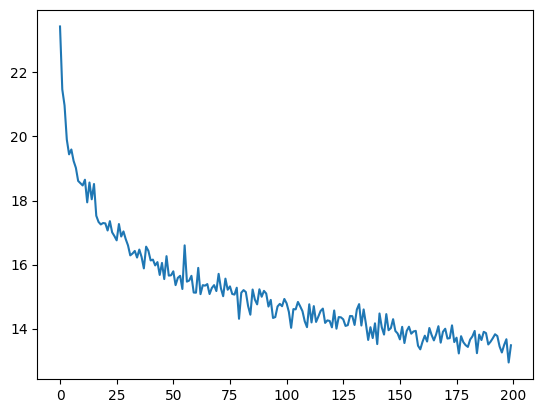

In [15]:
##################################################
## monitoring loss function during training
##################################################

plt.figure()
plt.plot(all_losses)
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.4.5: Investigate the training regime </span></strong>
>
> 1. What exactly is the loss function here? What are we training the model on: perplexity, average surprisal, or yet something else?
> It is negative log-likelihood loss. It is average surprisal.


Click below to see the solution.

```{toggle}
We have the loss function defined as the negative log likelihood loss, which is basically average surprisal. Especially since nn.NLLLoss has a parameter "reduction" which is set to "mean" by default.
```

## Evaluation & inference



Let&rsquo;s see what the model has learned and how well it does in producing new names.

Here are some auxiliary functions to obtain surprisal values and related notions for sequences of characters.
We can use them to compare the model&rsquo;s performance on the training and test data set.



In [16]:
##################################################
## evaluation
##################################################


def get_surprisal_item(category, name):
    category_tensor_ = category_tensor(category)
    input_line_tensor = input_tensor(name)
    target_line_tensor = target_tensor(name)
    hidden = rnn.init_hidden()
    surprisal = 0
    target_line_tensor.unsqueeze_(-1)

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor_, input_line_tensor[i], hidden, False)
        surprisal += criterion(output, target_line_tensor[i])
    return surprisal.item()


def get_surprisal_dataset(data):
    surprisl_dict = dict()
    surp_avg_dict = dict()
    perplxty_dict = dict()
    for category in list(data.keys()):
        surprisl = 0
        surp_avg = 0
        perplxty = 0
        # training
        for name in data[category]:
            item_surpr = get_surprisal_item(category, name)
            surprisl += item_surpr
            surp_avg += item_surpr / len(name)
            perplxty += item_surpr ** (-1 / len(name))
        n_items = len(data[category])

        surprisl_dict[category] = surprisl / n_items
        surp_avg_dict[category] = surp_avg / n_items
        perplxty_dict[category] = perplxty / n_items

    return (surprisl_dict, surp_avg_dict, perplxty_dict)


def make_df(surp_dict):
    p = pandas.DataFrame.from_dict(surp_dict)
    p = p.transpose()
    p.columns = ["surprisal", "surp_scaled", "perplexity"]
    return p


surprisal_test = make_df(get_surprisal_dataset(test_data))
surprisal_train = make_df(get_surprisal_dataset(train_data))

print("\nmean surprisal (test):", np.mean(surprisal_test["surprisal"]))
print("\nmean surprisal (train):", np.mean(surprisal_train["surprisal"]))


mean surprisal (test): 15.44156122088758

mean surprisal (train): 11.850367460338868


> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.4.6: Interpret the evaluation metric </span></strong>
>
> 1. What do these two last numbers represent? What&rsquo;s better: a higher or lower value? What do the two numbers tell us when we compare them?
> They are mean surprisal values, which are averages of losses. A low surprisal is better.Results indicate that the model performs better on the training set.


Click below to see the solution.

```{toggle}
These two values answer the question, how surprised the model is seeing the data. A higher value indicates more surprisal. We can see that the model is more surprised seeing the test set, which makes sense because it was trained on the train set while it has never seen the test set before.
```

## Inference



Let&rsquo;s also explore the trained model&rsquo;s predictions to compare them against our own intuitions of what might be typical names in a given country.

Here&rsquo;s a function that takes a country and an initial string, and it outputs a model prediction for how to continue that string.

Note that for each prediction step with the model, the model is embedded under `torch.no_grad()`. This setting means that gradients are not computed during the forward passes through the model. This setting is recommended for *inference* (for any neural net), i.e., when you don't want to train the model anymore (only use it for generating predictions). This allows to increase computational effiency and save memory.

In [17]:
##################################################
## prediction function
##################################################

max_length = 20


# make a prediction based on given sequence
def predict(category, initial_sequence):

    if len(initial_sequence) >= max_length:
        return initial_sequence

    category_tensor_ = category_tensor(category)
    input_line_tensor = input_tensor(initial_sequence)
    hidden = rnn.init_hidden()

    name = initial_sequence

    for i in range(input_line_tensor.size(0)):
        with torch.no_grad():
            output, hidden = rnn(category_tensor_, input_line_tensor[i], hidden, False)

    # greedy decoding: choosing the most likely guess
    topv, topi = output.topk(1)
    topi = topi[0][0]

    if topi == EOSIndex:
        return name
    else:
        name += all_letters[topi]

    return predict(category, name)


print(predict("German", "Müll"))
print(predict("German", "Müll"))
print(predict("German", "Müll"))
print(predict("German", "Müll"))

Müller
Müller
Müller
Müller


You can also probe the model with an empty string:



In [19]:
print(predict("Japanese", ""))
print(predict("Japanese", ""))
print(predict("Japanese", ""))
print(predict("Japanese", ""))
print(predict("German", ""))
print(predict("English", ""))

Kamata
Kamata
Kamata
Kamata
Bauner
Grost


> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.4.7: Explore the model&rsquo;s predictions </span></strong>
>
> 1. Play around with these prediction functions for a country or several of which you have robust intuitions about how names from that country might sound. Report on one feature that speaks in favor of the model, and one that suggests that the model is not perfect (or seriously flawed).
>  The one flaw of the model is it keeps predicting the same names when the same country or the character sequence is given, suggesting it overfits. The one good feature is that it captures patterns very-well.
> 2. Is the prediction function as implemented in this subsection stochastic or not?

It is not stochastic.

Click below to see the solution.

```{toggle}
The predict() function itself is not stochastic but rather deterministic, because it uses greedy decoding. This means it will always choose the next most likely character. The variance in the completions comes from the dropout layer in the models architecture leaving space for some randomness. Removing that layer during inference (as described above) will always lead to the same completion given the same input.
```

## Inverting the generation model



The model we have trained here could be consider a **speaker model**: the model generates language (very limited in scope but still).
Additionally, the model can be used to probe how likely a particular name would be (as a generated string) for a particular category/country.
So, essentially we get something like $P_{S}(name \mid category)$ as a speaker likelihood function.
For instance, we can do this:



In [20]:
print(get_surprisal_item("German", "Franke"))
print(get_surprisal_item("Arabic", "Franke"))

13.77774429321289
20.544687271118164


> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.4.8: Category prediction with Bayes rule </span></strong>
>
> 1. Use the model as a speaker likelihood function to compute, via Bayes rule, the probability $P(category\mid name)$ for the names &ldquo;Dovesky&rdquo;, &ldquo;Jackson&rdquo; and &ldquo;Satoshi&rdquo;. Compare the results against those obtained by the RNN-based classifier reported in [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) (all the way at the end).



Click below to see the solution.

In [21]:
# names_data
n_names = 0
for key in train_data:
    n_names += len(train_data[key])
n_categories = len(train_data)

In [22]:
# function to retrieve conditional probability for (name|country)
def get_prob(country, name):
    category_tensor_ = category_tensor(country)
    input_line_tensor = input_tensor(name)
    target_line_tensor = target_tensor(name)
    hidden = rnn.init_hidden()
    log_prob = 0

    for i in range(input_line_tensor.size(0)):

        output, hidden = rnn(category_tensor_, input_line_tensor[i], hidden, False)
        output = output.squeeze()
        log_prob += output[target_line_tensor[i]].detach().numpy()
    return np.exp(log_prob/input_line_tensor.size(0))


# get probability of categories
p_categories = {}
for key in names_data:
    p_categories[key] = len(names_data[key])/n_names

# get the conditional probabilities P(name|cat) from model
cond_prob_names = {"Doveski":[], "Jackson":[], "Satoshi":[]}
country2idx = {}
for i, key in enumerate(names_data):
    # create mapping from index to country
    country2idx[key] = i
    for name in cond_prob_names:
        prob = get_prob(key, name)
        cond_prob_names[name].append(prob)

# calculate probability of name as P(name) = sum(P(name|category) * P(category)) for all categories
p_names = {"Doveski":0, "Jackson":0, "Satoshi":0}
for name in p_names:
    for country in names_data:
        p_names[name] += cond_prob_names[name][country2idx[country]] * 1/18

# apply bayes law
for name in cond_prob_names:
    total = 0
    for country in names_data:
        # print(f"P({country} | {name}) = {(cond_prob_names[name][country2idx[country]] * p_categories[country]) / p_names[name]}")
        print(f"Logspace: P({country} | {name}) = {np.log((cond_prob_names[name][country2idx[country]] * 1/18) / p_names[name])}")
        total += (cond_prob_names[name][country2idx[country]] * 1/18) / p_names[name]
    print(total)
    print("\n------------------------------------------------------------------------\n")

Logspace: P(Czech | Doveski) = -2.2774643898010254
Logspace: P(German | Doveski) = -2.5991015434265137
Logspace: P(Arabic | Doveski) = -3.68674373626709
Logspace: P(Japanese | Doveski) = -3.150683879852295
Logspace: P(Chinese | Doveski) = -4.266093730926514
Logspace: P(Vietnamese | Doveski) = -4.516214370727539
Logspace: P(Russian | Doveski) = -2.217602252960205
Logspace: P(French | Doveski) = -3.0485265254974365
Logspace: P(Irish | Doveski) = -2.9182817935943604
Logspace: P(English | Doveski) = -2.630126714706421
Logspace: P(Spanish | Doveski) = -3.2798540592193604
Logspace: P(Greek | Doveski) = -2.8038394451141357
Logspace: P(Italian | Doveski) = -2.6790053844451904
Logspace: P(Portuguese | Doveski) = -3.931386947631836
Logspace: P(Scottish | Doveski) = -2.7779057025909424
Logspace: P(Dutch | Doveski) = -2.5868515968322754
Logspace: P(Korean | Doveski) = -5.119194984436035
Logspace: P(Polish | Doveski) = -2.1369545459747314
1.0000001

-------------------------------------------------

```{toggle}
While the numbers don't exactly match with the tutorial, the general tendency is the same except for "satoshi", where our model predicts more correctly japanese as the most likely class as opposed to italian in the tutorial.
```